In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os; os.chdir('C:\\work\\dev\\python\\progs\\scraper\\ufc\\')

In [3]:
import pandas as pd
import joblib

from ruamel.yaml import YAML
import re
import numpy as np

conf = YAML().load(open('params.yaml'))

# Данные

In [4]:
df = pd.read_csv(conf['feat_shortlist_sel']['feat_short_fn'])
nfeats = ['event', 'fighter', 'opponent', 'event_day', 'target', 'split']
feats = [it for it in df.columns if not it in nfeats]


In [5]:
idx_tr = df.query("split=='tr'").index.tolist()
idx_val = df.query("split=='val'").index.tolist()
fake_splitter = lambda df: [(idx_tr, idx_val)]
fake_splitter_all = lambda df: [(df.query("split=='tr'").index.tolist(), df.index.tolist())]

# Модель

In [9]:
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = Pipeline(steps=[('sc', RobustScaler()), ('clf', LogisticRegression(solver='liblinear', random_state=conf['seed']))])
# param_grid={'clf__penalty': ['l1'], 'clf__C': np.linspace(0.01,10, 100)}
param_grid={'clf__penalty': ['l1'], 'clf__C': np.logspace(-10,1, 100)}

def diff_scorer(target, pred):

    m_tr = roc_auc_score(target[idx_tr], pred[idx_tr])
    m_val = roc_auc_score(target[idx_val], pred[idx_val])
    
    return m_val - 10*int((m_tr-m_val)/m_tr>0.05)
    # return m_val
    
scorer_ = make_scorer(diff_scorer, greater_is_better=True, needs_proba=True)

gr_s = GridSearchCV(model, param_grid, cv = fake_splitter_all(df), scoring=scorer_, n_jobs=1)

gr_s.fit(df[feats], df['target'])

print(gr_s.best_score_, gr_s.best_params_)


0.6204215780470087 {'clf__C': 0.02782559402207126, 'clf__penalty': 'l1'}


In [11]:
best_model = gr_s.best_estimator_
# best_model = LogisticRegression(random_state=conf['seed'])
rocauc_tr_l = []
rocauc_val_l = []

for tr_idx, val_idx in fake_splitter(df):
    best_model.fit(df.loc[tr_idx, feats], df.loc[tr_idx, 'target'])
    rocauc_tr_l.append(roc_auc_score(df.loc[tr_idx, 'target'], best_model.predict_proba(df.loc[tr_idx, feats])[:,1]))
    rocauc_val_l.append(roc_auc_score(df.loc[val_idx, 'target'], best_model.predict_proba(df.loc[val_idx, feats])[:,1]))

print(np.mean(rocauc_tr_l), np.mean(rocauc_val_l))

0.5890759522001441 0.6204040025308744


# Метрики

In [12]:
from sklearn.metrics import roc_auc_score, average_precision_score
import json

df['score1'] = best_model.predict_proba(df[feats])[:, 1]

roc_d = {f'roc_auc_{sample}':roc_auc_score(df.loc[df.split==sample, 'target'], df.loc[df.split==sample, 'score1']) for sample in ['tr', 'val', 'ts']}
pr_d = {f'avg_pr_{sample}':average_precision_score(df.loc[df.split==sample, 'target'], df.loc[df.split==sample, 'score1']) for sample in ['tr', 'val', 'ts']}

d = {**roc_d, **pr_d}
d

{'roc_auc_tr': 0.5890759522001441,
 'roc_auc_val': 0.6204040025308744,
 'roc_auc_ts': 0.6402730445283636,
 'avg_pr_tr': 0.5939439893177583,
 'avg_pr_val': 0.6022207028042846,
 'avg_pr_ts': 0.6174840439071152}

In [ ]:
with open(conf['train_eval']['eval_fn'], 'wt') as f:
    json.dump(d, f)

In [38]:
DN = conf['train_eval']['report_dn']


# Графики

## гистограмма

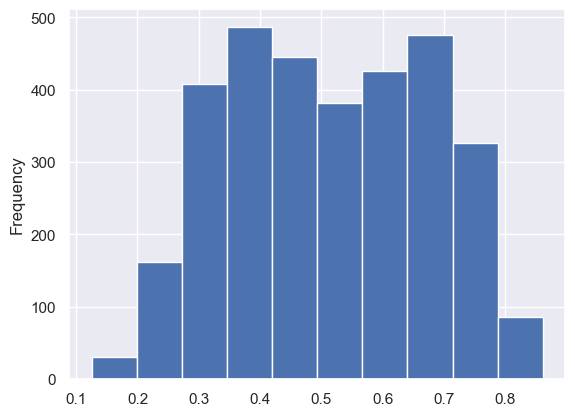

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


df['score1'].plot.hist()

plt.savefig(f'{DN}/hist.png')

In [8]:
df['score1'] = model.predict_proba(df[feats])[:, 1]

## калибровка

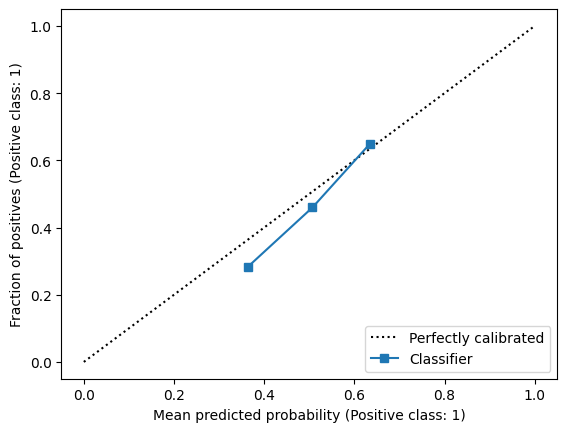

In [16]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(df.loc[df.split=='val', 'target'], df.loc[df.split=='val', 'score1'])

In [18]:
df.loc[df.split=='val', 'score1'].describe()

count    585.000000
mean       0.515261
std        0.081661
min        0.265865
25%        0.460931
50%        0.511038
75%        0.572957
max        0.729421
Name: score1, dtype: float64

In [51]:
from sklearn.calibration import CalibratedClassifierCV

model_cal = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv=5, n_jobs=-1, ensemble=False)
model_cal.fit(df.loc[df.split=='tr', feats], df.loc[df.split=='tr', 'target'])#.fit(df.loc[tr_idx, feats], df.loc[tr_idx, 'target'])

CalibratedClassifierCV(cv=5, ensemble=False,
                       estimator=LogisticRegression(random_state=0), n_jobs=-1)

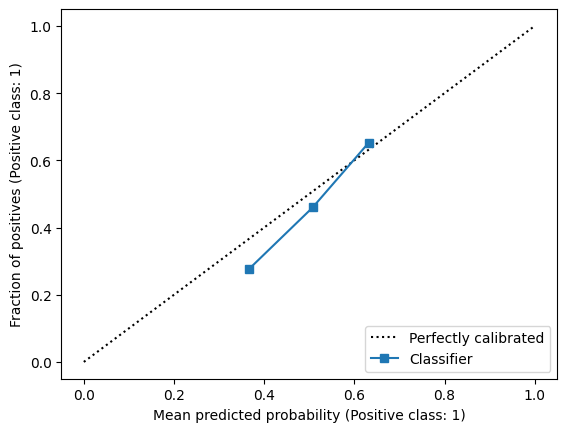

In [55]:
import matplotlib.pyplot as plt
DN = conf['train_eval']['report_dn']

CalibrationDisplay.from_predictions(df.loc[df.split=='val', 'target'], model_cal.predict_proba(df.loc[df.split=='val', feats])[:,1])
plt.savefig(f'{DN}/calibr.png')

# Остальное

## поиск границы для f1

In [ ]:
from sklearn.metrics import f1_score
thresh_l = []
f1_l = []
for thresh in np.linspace(0,1,100):
    df['y_p'] = (df['score1']>=thresh).astype(int)
    thresh_l.append(thresh)
    f1_l.append(f1_score(df.loc[df.split=='tr', 'target'], df.loc[df.split=='tr', 'y_p']))
f1_df = pd.DataFrame({'thresh': thresh_l, 'f1': f1_l})

f1_df = f1_df.sort_values(by='f1', ascending=False)
display(f1_df.head(5))
thresh = f1_df['thresh'].iloc[0]

display(f1_df[f1_df['thresh']>0.5].head())